**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

In [2]:
with open("companies.csv") as corpus_file:
    corpus = corpus_file.read()
    corpus_length = len(corpus)
    
print(f"Loaded a corpus of {corpus_length} characters")

#np.loadtxt("companies.csv", dtype=str, delimiter=";")

Loaded a corpus of 2567986 characters


In [3]:
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))

Our corpus contains 150 unique characters.


In [4]:
print(encoding)
print(decoding)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, '=': 28, '>': 29, '?': 30, '@': 31, 'A': 32, 'B': 33, 'C': 34, 'D': 35, 'E': 36, 'F': 37, 'G': 38, 'H': 39, 'I': 40, 'J': 41, 'K': 42, 'L': 43, 'M': 44, 'N': 45, 'O': 46, 'P': 47, 'Q': 48, 'R': 49, 'S': 50, 'T': 51, 'U': 52, 'V': 53, 'W': 54, 'X': 55, 'Y': 56, 'Z': 57, '[': 58, '\\': 59, ']': 60, '^': 61, '_': 62, 'a': 63, 'b': 64, 'c': 65, 'd': 66, 'e': 67, 'f': 68, 'g': 69, 'h': 70, 'i': 71, 'j': 72, 'k': 73, 'l': 74, 'm': 75, 'n': 76, 'o': 77, 'p': 78, 'q': 79, 'r': 80, 's': 81, 't': 82, 'u': 83, 'v': 84, 'w': 85, 'x': 86, 'y': 87, 'z': 88, '{': 89, '|': 90, '}': 91, '~': 92, '\x81': 93, '\x82': 94, '\x83': 95, '\x84': 96, '\x85': 97, '\x86': 98, '\x87': 99, '\x88': 100, '\x89': 101, '\x8a': 102, '\x8b': 103, '\x8c': 104, '\x8d': 105, '\x8e': 

## Many to One  approach

In [5]:
sequence_length = 10
skip = 3
X_data = []
y_data = []
for i in range (0, len(corpus) - sequence_length, skip):
    sequence = corpus[i:i+sequence_length]
    next_char = corpus[i+sequence_length]
    X_data.append([encoding[char] for char in sequence])
    y_data.append(encoding[next_char])

num_sequences = len(X_data)
print(f"Sliced our corpus into {num_sequences} sequences of length {sequence_length}")

Sliced our corpus into 855992 sequences of length 10


In [6]:
print(X_data[0])
print([decoding[c] for c in X_data[0]])
print(decoding[y_data[0]])

[39, 63, 81, 70, 78, 74, 63, 87, 1, 40]
['H', 'a', 's', 'h', 'p', 'l', 'a', 'y', ' ', 'I']
n


In [7]:
X = F.one_hot(torch.tensor(X_data), num_classes=num_chars).to(torch.float)
y = torch.tensor(y_data)

print(f"# sequences: {num_sequences}")
print(f"Characters in corpus: {len(chars)}")
print(f"sequence length: {sequence_length}")
print(f"Sanity check y. Dimension: {y.shape}")
print(f"Sanity check X. Dimension: {X.shape}")

# sequences: 855992
Characters in corpus: 150
sequence length: 10
Sanity check y. Dimension: torch.Size([855992])
Sanity check X. Dimension: torch.Size([855992, 10, 150])


In [8]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, num_classes):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, num_classes),
            nn.Softmax(dim=-1),
        )
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1]
        out = self.fc(out)
        return out

In [9]:
hidden_size = 64
num_classes = num_chars
layer_size = 1
batch_size= 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel(num_classes, hidden_size, layer_size, num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(batch_size, sequence_length, num_classes))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 --                        --
├─RNN: 1-1                               [128, 10, 64]             13,824
├─Sequential: 1-2                        [128, 150]                --
│    └─Linear: 2-1                       [128, 150]                9,750
│    └─Softmax: 2-2                      [128, 150]                --
Total params: 23,574
Trainable params: 23,574
Non-trainable params: 0
Total mult-adds (M): 18.94
Input size (MB): 0.77
Forward/backward pass size (MB): 0.81
Params size (MB): 0.09
Estimated Total Size (MB): 1.67

In [10]:
model

RNNModel(
  (rnn): RNN(150, 64, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=150, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [11]:
def train(epoch, model, data_loader, log_interval=200):
    model.train()
    total_train_loss = 0
    total_correct = 0 
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad() 
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)
        # Backpropagate. Updates the gradients buffer on each parameter
        loss.backward()
        # Update weights
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, pred = torch.max(output, dim=1)

        total_correct += torch.sum(pred == target).item()
                  
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))
    
    accuracy_train = total_correct / len(data_loader.dataset)

    
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [12]:
@torch.inference_mode() 
def predict(model, data):
    model.eval()
    output = model(data)
    return output

In [13]:
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [14]:
%%time

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 10
for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])

Training Epoch 1:   0%|          | 0/6688 [00:00<?, ?it/s]

Train Epoch: 1 [0/855992 (0%)]	Loss: 5.010685
Train Epoch: 1 [25600/855992 (3%)]	Loss: 4.936292
Train Epoch: 1 [51200/855992 (6%)]	Loss: 4.920770
Train Epoch: 1 [76800/855992 (9%)]	Loss: 4.889464
Train Epoch: 1 [102400/855992 (12%)]	Loss: 4.943903
Train Epoch: 1 [128000/855992 (15%)]	Loss: 4.865936
Train Epoch: 1 [153600/855992 (18%)]	Loss: 4.959515
Train Epoch: 1 [179200/855992 (21%)]	Loss: 4.982931
Train Epoch: 1 [204800/855992 (24%)]	Loss: 4.951705
Train Epoch: 1 [230400/855992 (27%)]	Loss: 4.928297
Train Epoch: 1 [256000/855992 (30%)]	Loss: 4.951712
Train Epoch: 1 [281600/855992 (33%)]	Loss: 4.920482
Train Epoch: 1 [307200/855992 (36%)]	Loss: 4.920481
Train Epoch: 1 [332800/855992 (39%)]	Loss: 4.975141
Train Epoch: 1 [358400/855992 (42%)]	Loss: 4.959520
Train Epoch: 1 [384000/855992 (45%)]	Loss: 4.920467
Train Epoch: 1 [409600/855992 (48%)]	Loss: 4.951710
Train Epoch: 1 [435200/855992 (51%)]	Loss: 4.982957
Train Epoch: 1 [460800/855992 (54%)]	Loss: 4.928284
Train Epoch: 1 [486400/8

Training Epoch 2:   0%|          | 0/6688 [00:00<?, ?it/s]

Train Epoch: 2 [0/855992 (0%)]	Loss: 4.833351
Train Epoch: 2 [25600/855992 (3%)]	Loss: 4.848730
Train Epoch: 2 [51200/855992 (6%)]	Loss: 4.791923
Train Epoch: 2 [76800/855992 (9%)]	Loss: 4.829117
Train Epoch: 2 [102400/855992 (12%)]	Loss: 4.808399
Train Epoch: 2 [128000/855992 (15%)]	Loss: 4.780657
Train Epoch: 2 [153600/855992 (18%)]	Loss: 4.826577
Train Epoch: 2 [179200/855992 (21%)]	Loss: 4.840570
Train Epoch: 2 [204800/855992 (24%)]	Loss: 4.753696
Train Epoch: 2 [230400/855992 (27%)]	Loss: 4.740283
Train Epoch: 2 [256000/855992 (30%)]	Loss: 4.769109
Train Epoch: 2 [281600/855992 (33%)]	Loss: 4.792164
Train Epoch: 2 [307200/855992 (36%)]	Loss: 4.820244
Train Epoch: 2 [332800/855992 (39%)]	Loss: 4.769356
Train Epoch: 2 [358400/855992 (42%)]	Loss: 4.796368
Train Epoch: 2 [384000/855992 (45%)]	Loss: 4.802536
Train Epoch: 2 [409600/855992 (48%)]	Loss: 4.763190
Train Epoch: 2 [435200/855992 (51%)]	Loss: 4.827420
Train Epoch: 2 [460800/855992 (54%)]	Loss: 4.828749
Train Epoch: 2 [486400/8

Training Epoch 3:   0%|          | 0/6688 [00:00<?, ?it/s]

Train Epoch: 3 [0/855992 (0%)]	Loss: 4.774034
Train Epoch: 3 [25600/855992 (3%)]	Loss: 4.700772
Train Epoch: 3 [51200/855992 (6%)]	Loss: 4.844039
Train Epoch: 3 [76800/855992 (9%)]	Loss: 4.812463
Train Epoch: 3 [102400/855992 (12%)]	Loss: 4.767422
Train Epoch: 3 [128000/855992 (15%)]	Loss: 4.791334
Train Epoch: 3 [153600/855992 (18%)]	Loss: 4.732358
Train Epoch: 3 [179200/855992 (21%)]	Loss: 4.693199
Train Epoch: 3 [204800/855992 (24%)]	Loss: 4.677909
Train Epoch: 3 [230400/855992 (27%)]	Loss: 4.783278
Train Epoch: 3 [256000/855992 (30%)]	Loss: 4.801521
Train Epoch: 3 [281600/855992 (33%)]	Loss: 4.788512
Train Epoch: 3 [307200/855992 (36%)]	Loss: 4.797509
Train Epoch: 3 [332800/855992 (39%)]	Loss: 4.797469
Train Epoch: 3 [358400/855992 (42%)]	Loss: 4.706284
Train Epoch: 3 [384000/855992 (45%)]	Loss: 4.760263
Train Epoch: 3 [409600/855992 (48%)]	Loss: 4.758116
Train Epoch: 3 [435200/855992 (51%)]	Loss: 4.718832
Train Epoch: 3 [460800/855992 (54%)]	Loss: 4.728637
Train Epoch: 3 [486400/8

Training Epoch 4:   0%|          | 0/6688 [00:00<?, ?it/s]

Train Epoch: 4 [0/855992 (0%)]	Loss: 4.786294
Train Epoch: 4 [25600/855992 (3%)]	Loss: 4.747069
Train Epoch: 4 [51200/855992 (6%)]	Loss: 4.809166
Train Epoch: 4 [76800/855992 (9%)]	Loss: 4.744350
Train Epoch: 4 [102400/855992 (12%)]	Loss: 4.730820
Train Epoch: 4 [128000/855992 (15%)]	Loss: 4.811648
Train Epoch: 4 [153600/855992 (18%)]	Loss: 4.669909
Train Epoch: 4 [179200/855992 (21%)]	Loss: 4.727087
Train Epoch: 4 [204800/855992 (24%)]	Loss: 4.729530
Train Epoch: 4 [230400/855992 (27%)]	Loss: 4.734234
Train Epoch: 4 [256000/855992 (30%)]	Loss: 4.736125
Train Epoch: 4 [281600/855992 (33%)]	Loss: 4.799965
Train Epoch: 4 [307200/855992 (36%)]	Loss: 4.736814
Train Epoch: 4 [332800/855992 (39%)]	Loss: 4.710070
Train Epoch: 4 [358400/855992 (42%)]	Loss: 4.733772
Train Epoch: 4 [384000/855992 (45%)]	Loss: 4.721423
Train Epoch: 4 [409600/855992 (48%)]	Loss: 4.675649
Train Epoch: 4 [435200/855992 (51%)]	Loss: 4.726267
Train Epoch: 4 [460800/855992 (54%)]	Loss: 4.712678
Train Epoch: 4 [486400/8

Training Epoch 5:   0%|          | 0/6688 [00:00<?, ?it/s]

Train Epoch: 5 [0/855992 (0%)]	Loss: 4.656658
Train Epoch: 5 [25600/855992 (3%)]	Loss: 4.623310
Train Epoch: 5 [51200/855992 (6%)]	Loss: 4.761882
Train Epoch: 5 [76800/855992 (9%)]	Loss: 4.694811
Train Epoch: 5 [102400/855992 (12%)]	Loss: 4.713318
Train Epoch: 5 [128000/855992 (15%)]	Loss: 4.732544
Train Epoch: 5 [153600/855992 (18%)]	Loss: 4.744422
Train Epoch: 5 [179200/855992 (21%)]	Loss: 4.678281
Train Epoch: 5 [204800/855992 (24%)]	Loss: 4.735976
Train Epoch: 5 [230400/855992 (27%)]	Loss: 4.757316
Train Epoch: 5 [256000/855992 (30%)]	Loss: 4.676985
Train Epoch: 5 [281600/855992 (33%)]	Loss: 4.721568
Train Epoch: 5 [307200/855992 (36%)]	Loss: 4.690185
Train Epoch: 5 [332800/855992 (39%)]	Loss: 4.749906
Train Epoch: 5 [358400/855992 (42%)]	Loss: 4.766503
Train Epoch: 5 [384000/855992 (45%)]	Loss: 4.732476
Train Epoch: 5 [409600/855992 (48%)]	Loss: 4.685112
Train Epoch: 5 [435200/855992 (51%)]	Loss: 4.726568
Train Epoch: 5 [460800/855992 (54%)]	Loss: 4.683387
Train Epoch: 5 [486400/8

Training Epoch 6:   0%|          | 0/6688 [00:00<?, ?it/s]

Train Epoch: 6 [0/855992 (0%)]	Loss: 4.744456
Train Epoch: 6 [25600/855992 (3%)]	Loss: 4.735473
Train Epoch: 6 [51200/855992 (6%)]	Loss: 4.744827
Train Epoch: 6 [76800/855992 (9%)]	Loss: 4.688704
Train Epoch: 6 [102400/855992 (12%)]	Loss: 4.727985
Train Epoch: 6 [128000/855992 (15%)]	Loss: 4.764800
Train Epoch: 6 [153600/855992 (18%)]	Loss: 4.741763
Train Epoch: 6 [179200/855992 (21%)]	Loss: 4.663023
Train Epoch: 6 [204800/855992 (24%)]	Loss: 4.784701
Train Epoch: 6 [230400/855992 (27%)]	Loss: 4.731513
Train Epoch: 6 [256000/855992 (30%)]	Loss: 4.763804
Train Epoch: 6 [281600/855992 (33%)]	Loss: 4.739939
Train Epoch: 6 [307200/855992 (36%)]	Loss: 4.777192
Train Epoch: 6 [332800/855992 (39%)]	Loss: 4.674311
Train Epoch: 6 [358400/855992 (42%)]	Loss: 4.693240
Train Epoch: 6 [384000/855992 (45%)]	Loss: 4.713624
Train Epoch: 6 [409600/855992 (48%)]	Loss: 4.687284
Train Epoch: 6 [435200/855992 (51%)]	Loss: 4.717800
Train Epoch: 6 [460800/855992 (54%)]	Loss: 4.683241
Train Epoch: 6 [486400/8

Training Epoch 7:   0%|          | 0/6688 [00:00<?, ?it/s]

Train Epoch: 7 [0/855992 (0%)]	Loss: 4.767110
Train Epoch: 7 [25600/855992 (3%)]	Loss: 4.675468
Train Epoch: 7 [51200/855992 (6%)]	Loss: 4.725726
Train Epoch: 7 [76800/855992 (9%)]	Loss: 4.728878
Train Epoch: 7 [102400/855992 (12%)]	Loss: 4.707928
Train Epoch: 7 [128000/855992 (15%)]	Loss: 4.698589
Train Epoch: 7 [153600/855992 (18%)]	Loss: 4.635870
Train Epoch: 7 [179200/855992 (21%)]	Loss: 4.730591
Train Epoch: 7 [204800/855992 (24%)]	Loss: 4.780990
Train Epoch: 7 [230400/855992 (27%)]	Loss: 4.754541
Train Epoch: 7 [256000/855992 (30%)]	Loss: 4.696138
Train Epoch: 7 [281600/855992 (33%)]	Loss: 4.726100
Train Epoch: 7 [307200/855992 (36%)]	Loss: 4.695783
Train Epoch: 7 [332800/855992 (39%)]	Loss: 4.732627
Train Epoch: 7 [358400/855992 (42%)]	Loss: 4.711653
Train Epoch: 7 [384000/855992 (45%)]	Loss: 4.825142
Train Epoch: 7 [409600/855992 (48%)]	Loss: 4.686516
Train Epoch: 7 [435200/855992 (51%)]	Loss: 4.684203
Train Epoch: 7 [460800/855992 (54%)]	Loss: 4.781425
Train Epoch: 7 [486400/8

Training Epoch 8:   0%|          | 0/6688 [00:00<?, ?it/s]

Train Epoch: 8 [0/855992 (0%)]	Loss: 4.715795
Train Epoch: 8 [25600/855992 (3%)]	Loss: 4.606381
Train Epoch: 8 [51200/855992 (6%)]	Loss: 4.717302
Train Epoch: 8 [76800/855992 (9%)]	Loss: 4.672729
Train Epoch: 8 [102400/855992 (12%)]	Loss: 4.635515
Train Epoch: 8 [128000/855992 (15%)]	Loss: 4.680321
Train Epoch: 8 [153600/855992 (18%)]	Loss: 4.650402
Train Epoch: 8 [179200/855992 (21%)]	Loss: 4.690157
Train Epoch: 8 [204800/855992 (24%)]	Loss: 4.723172
Train Epoch: 8 [230400/855992 (27%)]	Loss: 4.649329
Train Epoch: 8 [256000/855992 (30%)]	Loss: 4.689195
Train Epoch: 8 [281600/855992 (33%)]	Loss: 4.701008
Train Epoch: 8 [307200/855992 (36%)]	Loss: 4.667573
Train Epoch: 8 [332800/855992 (39%)]	Loss: 4.742779
Train Epoch: 8 [358400/855992 (42%)]	Loss: 4.720887
Train Epoch: 8 [384000/855992 (45%)]	Loss: 4.727548
Train Epoch: 8 [409600/855992 (48%)]	Loss: 4.718256
Train Epoch: 8 [435200/855992 (51%)]	Loss: 4.741251
Train Epoch: 8 [460800/855992 (54%)]	Loss: 4.662913
Train Epoch: 8 [486400/8

Training Epoch 9:   0%|          | 0/6688 [00:00<?, ?it/s]

Train Epoch: 9 [0/855992 (0%)]	Loss: 4.684129
Train Epoch: 9 [25600/855992 (3%)]	Loss: 4.694532
Train Epoch: 9 [51200/855992 (6%)]	Loss: 4.782624
Train Epoch: 9 [76800/855992 (9%)]	Loss: 4.712178
Train Epoch: 9 [102400/855992 (12%)]	Loss: 4.713583
Train Epoch: 9 [128000/855992 (15%)]	Loss: 4.635890
Train Epoch: 9 [153600/855992 (18%)]	Loss: 4.646721
Train Epoch: 9 [179200/855992 (21%)]	Loss: 4.699159
Train Epoch: 9 [204800/855992 (24%)]	Loss: 4.743248
Train Epoch: 9 [230400/855992 (27%)]	Loss: 4.711519
Train Epoch: 9 [256000/855992 (30%)]	Loss: 4.720269
Train Epoch: 9 [281600/855992 (33%)]	Loss: 4.707355
Train Epoch: 9 [307200/855992 (36%)]	Loss: 4.687472
Train Epoch: 9 [332800/855992 (39%)]	Loss: 4.702065
Train Epoch: 9 [358400/855992 (42%)]	Loss: 4.716147
Train Epoch: 9 [384000/855992 (45%)]	Loss: 4.708540
Train Epoch: 9 [409600/855992 (48%)]	Loss: 4.668269
Train Epoch: 9 [435200/855992 (51%)]	Loss: 4.723232
Train Epoch: 9 [460800/855992 (54%)]	Loss: 4.668338
Train Epoch: 9 [486400/8

Training Epoch 10:   0%|          | 0/6688 [00:00<?, ?it/s]

Train Epoch: 10 [0/855992 (0%)]	Loss: 4.724474
Train Epoch: 10 [25600/855992 (3%)]	Loss: 4.737867
Train Epoch: 10 [51200/855992 (6%)]	Loss: 4.689765
Train Epoch: 10 [76800/855992 (9%)]	Loss: 4.777081
Train Epoch: 10 [102400/855992 (12%)]	Loss: 4.675215
Train Epoch: 10 [128000/855992 (15%)]	Loss: 4.732692
Train Epoch: 10 [153600/855992 (18%)]	Loss: 4.701852
Train Epoch: 10 [179200/855992 (21%)]	Loss: 4.724959
Train Epoch: 10 [204800/855992 (24%)]	Loss: 4.710461
Train Epoch: 10 [230400/855992 (27%)]	Loss: 4.718573
Train Epoch: 10 [256000/855992 (30%)]	Loss: 4.738539
Train Epoch: 10 [281600/855992 (33%)]	Loss: 4.651292
Train Epoch: 10 [307200/855992 (36%)]	Loss: 4.726159
Train Epoch: 10 [332800/855992 (39%)]	Loss: 4.673893
Train Epoch: 10 [358400/855992 (42%)]	Loss: 4.743781
Train Epoch: 10 [384000/855992 (45%)]	Loss: 4.716176
Train Epoch: 10 [409600/855992 (48%)]	Loss: 4.695560
Train Epoch: 10 [435200/855992 (51%)]	Loss: 4.708025
Train Epoch: 10 [460800/855992 (54%)]	Loss: 4.724327
Train

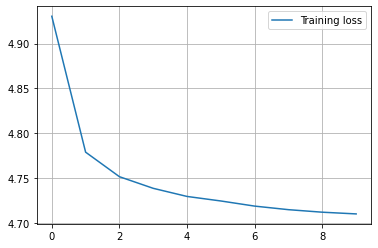

In [15]:
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.grid()

In [61]:
def make_seed(seed_phrase=""):
        if seed_phrase:
            phrase_length = len(seed_phrase)
            pattern = ""
            for i in range (0, sequence_length):
                pattern += seed_phrase[i % phrase_length]
        else:
            seed = random.randint(0, corpus_length - sequence_length)
            pattern = corpus[seed:seed + sequence_length]
        return pattern

seed_pattern = make_seed()
print(f"seed = \"{seed_pattern}\"")

encoded_text = torch.tensor([encoding[char] for char in seed_pattern])
encoded_text = F.one_hot(encoded_text, num_classes=num_chars).to(torch.float)
encoded_text = encoded_text.unsqueeze(0)
encoded_text = encoded_text.to(device)

generated_text = ""
for i in range(20):
    output = predict(model, encoded_text).squeeze()

    prediction = torch.multinomial(output, num_samples=1)
    #prediction = output.argmax()

    generated_text += decoding[int(prediction)]
  
    next_char_encoded = F.one_hot(prediction, num_classes=num_chars)
    next_char_encoded = next_char_encoded.view(1, 1, num_chars)
    encoded_text = torch.cat((encoded_text[:, 1:], next_char_encoded), dim=1)

print(generated_text)

seed = "loud Compu"
rent Sore Sore Sone



# TODO

## Many to many approach
!TO DO: the `forward()` function of the `mmRNNmodel()` below needs to be updated to fit the many2many approach

In [26]:
# chop up our data into X and y, slice into roughly 
# (num_chars / skip) overlapping 'sequences' of length 
# sequence_length, and encode the chars
sequence_length = 20
skip = 1
X_data = []
y_data = []
for i in range (0, len(corpus) - sequence_length, skip):
    sequence = corpus[i:i + sequence_length]
    next_char = corpus[i+1:i+1 + sequence_length]
    X_data.append([encoding[char] for char in sequence])
    y_data.append([encoding[char] for char in next_char])

num_sequences = len(X_data)
print("Sliced our corpus into {0} sequences of length {1}"
      .format(num_sequences, sequence_length))

Sliced our corpus into 1115374 sentences of length 20


In [27]:
print(X_data[0])

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56]


In [28]:
print([decoding[idx] for idx in X_data[0]])
print([decoding[idx] for idx in y_data[0]])


['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'B', 'e', 'f', 'o', 'r']
['i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'B', 'e', 'f', 'o', 'r', 'e']


In [29]:
# One-hot encode the data.
X = F.one_hot(torch.tensor(X_data), num_classes=num_chars).to(torch.float)
y = torch.tensor(y_data)

In [30]:
# Let's define the model
class mmRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, num_classes):
        super().__init__()
        
        # Defining the number of h layers and the nodes in each layer
        self.layer_size = layer_size
        self.hidden_size = hidden_size
        
        # RNN layers
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)
        
    # TO DO: Needs to be adapted to the many2many configuration
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1]
        out = self.fc(out)
        
        return out

In [31]:
hidden_size = 256
seq_length = 20
num_classes = 65
layer_size = 1
batch_size= 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelmm = mmRNNModel(num_classes, hidden_size, layer_size, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

summary(modelmm, input_size=(batch_size, seq_length, num_classes))

Layer (type:depth-idx)                   Output Shape              Param #
mmRNNModel                               --                        --
├─RNN: 1-1                               [128, 20, 256]            82,688
├─Linear: 1-2                            [128, 65]                 16,705
Total params: 99,393
Trainable params: 99,393
Non-trainable params: 0
Total mult-adds (M): 213.82
Input size (MB): 0.67
Forward/backward pass size (MB): 5.31
Params size (MB): 0.40
Estimated Total Size (MB): 6.37

In [32]:
#training time
def train(epoch, model, data_loader, log_interval=200):
    model.train()
    total_train_loss = 0
    total_correct = 0 
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad() 
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)
        # Backpropagate. Updates the gradients buffer on each parameter
        loss.backward()
        # Update weights
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, pred = torch.max(output, dim=1)

        total_correct += torch.sum(pred == target).item()
                  
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))
    
    accuracy_train = total_correct / len(data_loader.dataset)

    
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [33]:
@torch.inference_mode() 
def predict(model, data):
    # Put the model in eval mode, which disables training specific behaviour.
    model.eval()
    output = model(data)
    return output

In [34]:
# Create dataloader from X,y tensors
datasett = TensorDataset(X, y)
train_loader = DataLoader(datasett, batch_size=batch_size, shuffle=True)

In [35]:
%%time
# train the model

# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 10
for epoch in range(1, epochs + 1):
    train_result = train(epoch, modelmm, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    

plt.plot(train_losses, label='Training loss')
plt.legend()
plt.grid()

UsageError: Line magic function `%%time` not found.


In [ ]:
def make_seed(seed_phrase=""):
        if seed_phrase:  # make sure the seed has the right length
            phrase_length = len(seed_phrase)
            pattern = ""
            for i in range (0, sequence_length):
                pattern += seed_phrase[i % phrase_length]
        else:            # sample randomly the seed from corpus
            seed = random.randint(0, corpus_length - sequence_length)
            pattern = corpus[seed:seed + sequence_length]
        return pattern

seed_pattern = make_seed("In the early morning, the flower is shining")

encoded_text = torch.tensor([encoding[char] for char in seed_pattern])
encoded_text = F.one_hot(encoded_text, num_classes=num_chars).to(torch.float)
# Add a single batch dimension at the beginning
encoded_text = encoded_text.unsqueeze(0)
encoded_text = encoded_text.to(device)

generated_text = ""
for i in range(500):
    output = predict(modelmm, encoded_text)[0]
    # Convert the output to probabilities
    probs = torch.softmax(output, dim=-1)
    # Randomly choose from a multinomial distribution with the output probabilities
    # make the generation more diverse.
    prediction = torch.multinomial(probs, num_samples=1)
    generated_text += decoding[int(prediction)]
    
    # One hot encode the new (predicted) character
    next_char_encoded = F.one_hot(prediction, num_classes=num_chars)
    # Make sure it has a singular batch and seq_len dimension in order to concatenate them.
    next_char_encoded = next_char_encoded.view(1, 1, num_chars)
    # Remove first char and glue the predicted one to the end
    encoded_text = torch.cat((encoded_text[:, 1:], next_char_encoded), dim=1)
print(generated_text)